# Rosenbrock using Neighbourhood Algorithm

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial import voronoi_plot_2d, Voronoi

from napy import NASearcher, NAAppariser

The Rosenbrock function is a common optimisation test function given by 
$$f(x,y) = (a-x)^2 + b(y - x^2)^2$$
and has a global minimum at $(a, a^2)$

In [2]:
def rosenbrock(x, y, a=1, b=100):
    return np.log10((a - x) ** 2 + b * (y - x**2) ** 2)  # log10 to avoid very large/small values

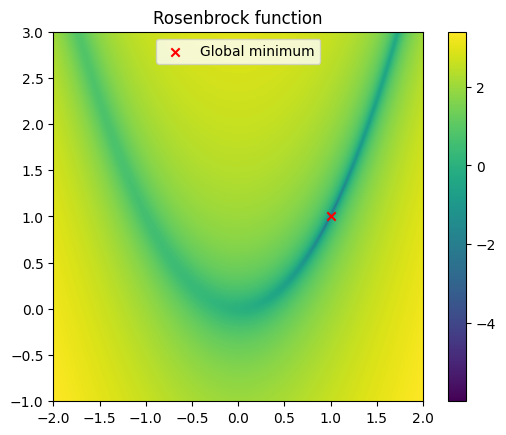

In [49]:
X, Y = np.meshgrid(np.linspace(-2, 2, 1000), np.linspace(-1, 3, 1000))
plt.imshow(rosenbrock(X, Y), origin="lower", extent=(-2, 2, -1, 3))
plt.colorbar()
plt.scatter(1, 1, c="r", marker="x", label="Global minimum")
plt.title("Rosenbrock function")
plt.legend(loc="upper center")

Neighbourhood Algorithm

In [4]:
def objective(params):
    return rosenbrock(*params)


searcher = NASearcher(
    objective,
    ns=70,
    nr=10,
    ni=100,
    n=20,
    bounds=((-2, 2), (-1, 3)),
)
searcher.run()

best = searcher.samples[np.argmin(searcher.objectives)]

(-1.0, 3.0)

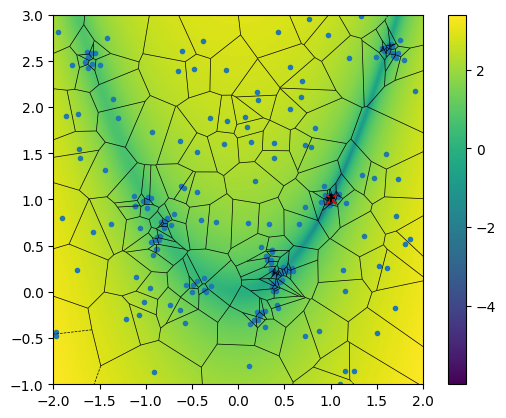

In [18]:

fig = voronoi_plot_2d(Voronoi(searcher.samples), show_vertices=False, line_width=0.5)
ax = fig.gca()
im = ax.imshow(rosenbrock(X, Y), origin="lower", extent=(-2, 2, -1, 3))
fig.colorbar(im)
ax.scatter(1, 1, c="r", marker="x", s=50, zorder=10)
ax.scatter(*best, c="k", marker="+", zorder=10)
ax.set_xlim(-2, 2)
ax.set_ylim(-1, 3)

Neighbourhood Algorithm - Appraisal

In [25]:
appraiser = NAAppariser(
    searcher.samples,
    np.exp(-searcher.objectives),
    bounds=((-2, 2), (-1, 3)),
    n_resample=5000,
    n_walkers=10,
)

results = appraiser.appraise(save=True)

Text(0.5, 1.0, 'NA-I and NA-II on Rosenbrock function')

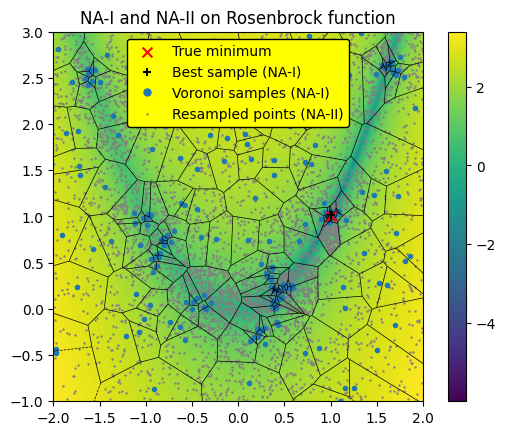

In [43]:
fig = voronoi_plot_2d(Voronoi(searcher.samples), show_vertices=False, line_width=0.5)
ax = fig.gca()
im = ax.imshow(rosenbrock(X, Y), origin="lower", extent=(-2, 2, -1, 3))
fig.colorbar(im)
_truth = ax.scatter(1, 1, c="r", marker="x", s=50, zorder=2, label="True minimum")
_best = ax.scatter(*best, c="k", marker="+", zorder=2, label="Best sample (NA-I)")
_resample = ax.scatter(
    *results["samples"].T, s=0.5, c="grey", zorder=0, label="Resampled points (NA-II)"
)
_voronoi = Line2D([0], [0], marker="o", label="Voronoi samples (NA-I)", markersize=5, linewidth=0)

ax.set_xlim(-2, 2)
ax.set_ylim(-1, 3)
ax.legend(
    handles=[_truth, _best, _voronoi, _resample],
    framealpha=1,
    facecolor="yellow",
    edgecolor="black",
)
ax.set_title("NA-I and NA-II on Rosenbrock function")